In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('Fraud.csv')
print(df.shape)
print(df.head())

(6362620, 11)
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


# Data Dictionary
step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information 
for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for 
customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control of customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [3]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [4]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


As evident from the Data Dictionary, Merchant recipient records does not provide values for attributes: oldbalanceDest and newbalanceDest.
Therefore, the transaction amount received by the recipient cannot be checked for dedection of fraudulant activites. This might skewer the output of machine learning model for predicting Fraud in transactions.

In [6]:
df_new = df[df['nameDest'].str.contains('M') == False]
df_new.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.00,1,0
9,1,DEBIT,5337.77,C712410124,41720.0,36382.23,C195600860,41898.0,40348.79,0,0
10,1,DEBIT,9644.94,C1900366749,4465.0,0.00,C997608398,10845.0,157982.12,0,0
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.00,C476402209,5083.0,51513.44,0,0


In [7]:
total_transactions = len(df_new)
fraud_transactions = len(df_new[df_new.isFraud == 1])
print(fraud_transactions)
print(total_transactions)
print("Percent of fraud transactions is: {:.4f} %".format((fraud_transactions * 100)/ total_transactions))

8213
4211125
Percent of fraud transactions is: 0.1950 %


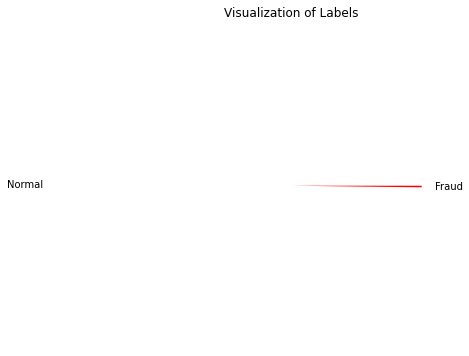

In [8]:
plt.figure(figsize=(6,6))
count_classes = df_new.value_counts(df_new['isFraud'], sort= True)
mylabels = ["Normal", "Fraud"]
mycolors = ['white', 'red']
myexplode = [0.8, 0]
plt.pie(count_classes, labels = mylabels, colors = mycolors, explode = myexplode)
plt.show()

As we can see the number of fraud detected transactions is \< 0.5% which is very low.
This creates a unbalanced relationship between fraud and real transactions. This type of classification should be done by Random Forest Classifier Algorithm

<AxesSubplot:>

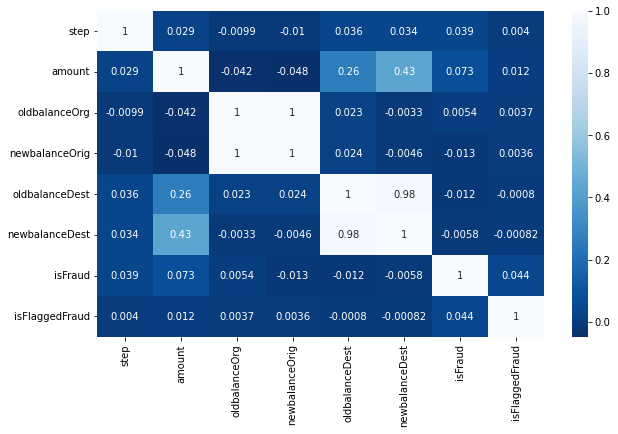

In [9]:
correlation = df_new.corr()
plt.figure(figsize=(10,6))
sns.heatmap(correlation,annot=True, cmap='Blues_r')

From the above heatmap, it is clear that oldbalanceOrig and newbalanceOrig are directly correlated and have very high correlation. Similarly, the oldbalanceDest and newbalanceDest are also directly correlated as evident by correlation number being very close to 1.
Therefore, to build a machine learning model with good accuracy, these columns need to be removed or operated, so that there is no skewer in the final output of the model.

We will further check the correlation among the attributes of the dataframe by checking the Multicollinearity score.

In [10]:
objList = df_new.select_dtypes(include = "object").columns

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
for att in objList:
    df_new[att] = encoder.fit_transform(df_new[att].astype(str))

print(df_new.head())

C:\Users\HSR\AppData\Local\Temp\ipykernel_15092\2953107148.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[att] = encoder.fit_transform(df_new[att].astype(str))


    step  type     amount  nameOrig  oldbalanceOrg  newbalanceOrig  nameDest  \
2      1     3     181.00    663412          181.0            0.00    439685   
3      1     1     181.00   3859208          181.0            0.00    391696   
9      1     2    5337.77   3580202        41720.0        36382.23    282960   
10     1     2    9644.94   1958055         4465.0            0.00    571261   
15     1     1  229133.94   4000507        15325.0            0.00    417183   

    oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
2              0.0            0.00        1               0  
3          21182.0            0.00        1               0  
9          41898.0        40348.79        0               0  
10         10845.0       157982.12        0               0  
15          5083.0        51513.44        0               0  


In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def check_multiCollinearity(df_new):
    vif = pd.DataFrame()
    vif["variables"] = df_new.columns
    for i in range(df_new.shape[1]):
        vif["VIF"] = variance_inflation_factor(df_new.values, i)
    return(vif)

check_multiCollinearity(df_new)

,variables,VIF
0,step,1.002627
1,type,1.002627
2,amount,1.002627
3,nameOrig,1.002627
4,oldbalanceOrg,1.002627
5,newbalanceOrig,1.002627
6,nameDest,1.002627
7,oldbalanceDest,1.002627
8,newbalanceDest,1.002627
9,isFraud,1.002627


Here again it is clear that oldbalanceOrg and newbalanceOrig are highly correlated as they have too high VIF.
Similarly for oldbalanceDest and newbalanceDest, also nameDest and nameOrig are correlated.

We can solve this issue by performing operation on the attributes which are related.

In [13]:
df_new['orig_transaction_amount'] = df_new.apply(lambda x: x['oldbalanceOrg'] - x['newbalanceOrig'],axis=1)
df_new['dest_transaction_amount'] = df_new.apply(lambda x: x['oldbalanceDest'] - x['newbalanceDest'],axis=1)
df_new['transaction_between'] = df_new.apply(lambda x: x['nameOrig'] + x['nameDest'],axis=1)

C:\Users\HSR\AppData\Local\Temp\ipykernel_15092\4090104073.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['orig_transaction_amount'] = df_new.apply(lambda x: x['oldbalanceOrg'] - x['newbalanceOrig'],axis=1)
C:\Users\HSR\AppData\Local\Temp\ipykernel_15092\4090104073.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['dest_transaction_amount'] = df_new.apply(lambda x: x['oldbalanceDest'] - x['newbalanceDest'],axis=1)
C:\Users\HSR\AppData\Local\Temp\ipykernel_15092\4090104073.py:3: SettingW

Now we can remove the previous columns.

In [14]:
df_new = df_new.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','step','nameOrig','nameDest'],axis=1)

Calculating the multicollinearity again

In [15]:
check_multiCollinearity(df_new)

,variables,VIF
0,type,1.960903
1,amount,1.960903
2,isFraud,1.960903
3,isFlaggedFraud,1.960903
4,orig_transaction_amount,1.960903
5,dest_transaction_amount,1.960903
6,transaction_between,1.960903


<AxesSubplot:>

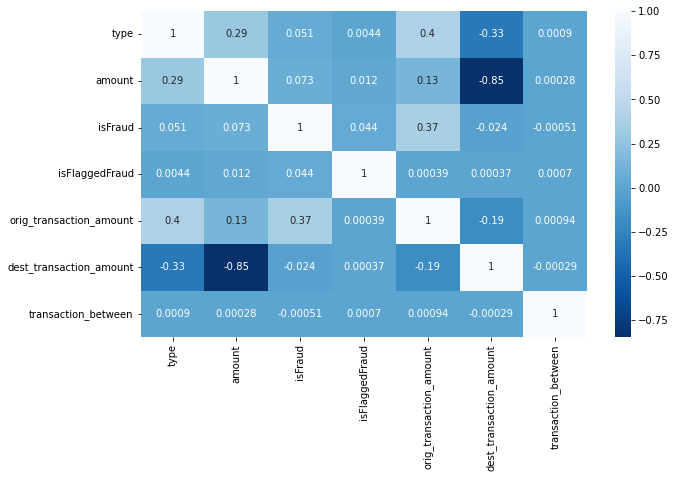

In [16]:
correlation = df_new.corr()
plt.figure(figsize=(10,6))
sns.heatmap(correlation,annot=True, cmap='Blues_r')

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import itertools
from collections import Counter
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [18]:
scaler = StandardScaler()
df_new["NormalizedAmount"] = scaler.fit_transform(df_new["amount"].values.reshape(-1, 1))
df_new.drop(["amount"], inplace= True, axis= 1)

Y = df_new["isFraud"]
X = df_new.drop(["isFraud"], axis= 1)

In [19]:
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size= 0.3, random_state= 42)

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (2947787, 6)
Shape of X_test:  (1263338, 6)


In [21]:
# RANDOM FOREST

random_forest = RandomForestClassifier(n_estimators = 100)
random_forest.fit(X_train, Y_train)

Y_pred_rf = random_forest.predict(X_test)
random_forest_score = random_forest.score(X_test, Y_test) * 100

In [22]:
# Print score
print("Random Forest Score: ", random_forest_score)

Random Forest Score:  99.93889204630906


In [23]:
# confusion matrix - RF

conf_matrix = confusion_matrix(Y_test, Y_pred_rf.round())
print(conf_matrix)

[[1260851      57]
 [    715    1715]]


In [24]:
rf = classification_report(Y_test, Y_pred_rf)
print("Classification Report - Random Forest")
print(rf)

Classification Report - Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1260908
           1       0.97      0.71      0.82      2430

    accuracy                           1.00   1263338
   macro avg       0.98      0.85      0.91   1263338
weighted avg       1.00      1.00      1.00   1263338



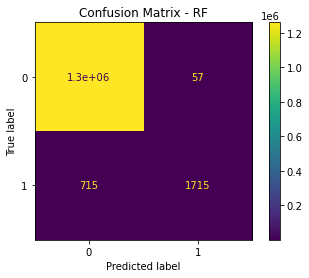

In [27]:
# visualising confusion matrix - RF
disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)
disp.plot()
plt.title('Confusion Matrix - RF')
plt.show()

# CONCLUSION

We have created a machine learning model using Random Forest to predict Fraud Transaction. Due to the nature of dataset being highly skewed towards one classification, Random Forest algorithm is the preferred choice for creating the Machine Learning Model since the data is tested in multiple decision trees causing it to be caliberated well.

After analyzing the results from the Fraud Detection model, let's discuss the response to the questions.

#### Data cleaning including missing values, outliers and multi-collinearity.
It is clear from the nature of transactions, we require the information of balance of recipient to verify fraud in transaction, thus we had to separate the transactions done to Merchant accounts as the information about their old and new balance was not accessible. 

We also check the multicollinearity between the columns and find the decisive factors for fraud detection in the account transactions.

#### How did you select variables to be included in the model?
We select the variables to be included in training and testing of the model by checking the Variance Inflation Factor. For attributes containing high reltivity to the output of the machine learning model, which in this case is the isFraud column.

#### What are the key factors that predict fraudulent customer?
Does a transaction is being done in regular intervals of time by the same customer?
If the amount of transaction is equal to the oldbalance of the sender's account.
If a transaction of high amount is made from a customer having the history of making small transactions.
Does a sequence of transactions is made by customer to one another in the same step?

#### Do these factors make sense? If yes, How? If not, How not?
All transactions are made based on a series of events. If a customer performs regular transactions of similar amounts, that might mean that he is paying for a commodity which is regularly used. Hence a sudden spike in the amount of transaction means that an agent might be doing fraud.

All customer accounts whether held by normal people or merchants, does make a trend in the long run. If a transactions is made which does not line up with the trend, it may be a fraudulent transaction.

#### What kind of prevention should be adopted while company update its infrastructure?
Use smart vertified apps only.
Use secured internet connections while making transactions and filling important personal details.
Keep your mobile and laptop security updated.
If you feel like you have been tricked or security compromised, contact your bank immidiately.

#### Assuming these actions have been implemented, how would you determine if they work?
Bank sending E-statements.
Customers keeping a check of their account activity.
Always keep a log of your payments.